<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning/blob/main/HW_14_stroika_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. На основе учебного ноутбука, проведите финальную подготовку данных. измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW 
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

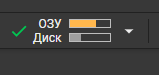


Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка


### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, Dropout
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Импортируем библиотеку numpy
import numpy as np 

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами 
import os 

# Для генерации случайных чисел 
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image 

# очистка ОЗУ
import gc 

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака
#gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_1024x768.zip', None, quiet=True)
#gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_512x384.zip', None, quiet=True)
gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_256x192.zip', None, quiet=True)

!unzip -q 'construction_256x192.zip' # распоковываем архив

In [ ]:
# Глобальные параметры

IMG_WIDTH = 192              # Ширина картинки 
IMG_HEIGHT = 256              # Высота картинки 
CLASS_COUNT = 16              # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

In [ ]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')): 

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))               
        
    # Вывод времени загрузки картинок выборки    
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title, 
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list)) 

    return image_list

In [ ]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n): 
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.27 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 100


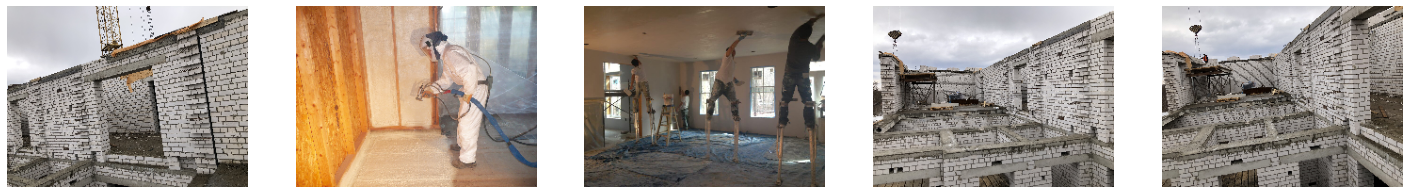

In [ ]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.24 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 100


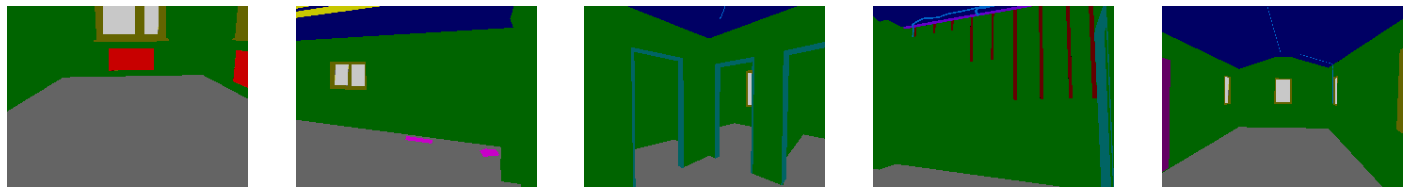

In [ ]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений 
                 ):

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i 

        result.append(y)
  
    return np.array(result)

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений 
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)
  
    return np.array(result)

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(1900, 192, 256, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(100, 192, 256, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


In [ ]:
# Цвета пикселов сегментированных изображений

FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

In [ ]:
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

меняем количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW 
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE


In [ ]:
y_train7 = y_train.copy()

y_train7[(y_train7 == 4)], y_train7[(y_train7 == 3)]  = 3, 4
y_train7[(y_train7 == 5)] = 3
y_train7[(y_train7 == 6)] = 3


y_train7[(y_train7 == 8)] = 4
y_train7[(y_train7 == 11)]  = 4

y_train7[(y_train7 == 12)] = 5

y_train7[(y_train7 >= 9) & (y_train7 !=11)] = 6
y_train7[(y_train7 == 7)] = 6


In [ ]:
unique7, counts7 = np.unique(y_train7, return_counts=True)

print (np.asarray((unique7, counts7)).T)

[[       0 17153712]
 [       1  8556970]
 [       2 47767734]
 [       3  2028774]
 [       4  4308430]
 [       5  7246526]
 [       6  6326654]]


In [ ]:
print(y_train7.shape)

(1900, 192, 256, 1)


In [ ]:
y_val7 = y_val.copy()
y_val7[(y_val7 == 4)], y_val7[(y_val7 == 3)]  = 3, 4
y_val7[(y_val7 == 5)] = 3
y_val7[(y_val7 == 6)] = 3


y_val7[(y_val7 == 8)] = 4
y_val7[(y_val7 == 11)]  = 4

y_val7[(y_val7 == 12)] = 5

y_val7[(y_val7 >= 9) & (y_val7 !=11)] = 6
y_val7[(y_val7 == 7)] = 6

In [ ]:
unique71, counts71 = np.unique(y_val7, return_counts=True)

print (np.asarray((unique71, counts71)).T)

[[      0  813117]
 [      1  708511]
 [      2 2244291]
 [      3  123185]
 [      4  261939]
 [      5  293996]
 [      6  470161]]


In [ ]:
print(y_val7.shape)

(100, 192, 256, 1)


In [ ]:
num_classes = 7

In [ ]:
# Вычисление количества пикселов по всем классам в y_train

pix_count = np.zeros(num_classes)
for i in range(num_classes):
    pix_count[i] = (y_train7 == i).sum()

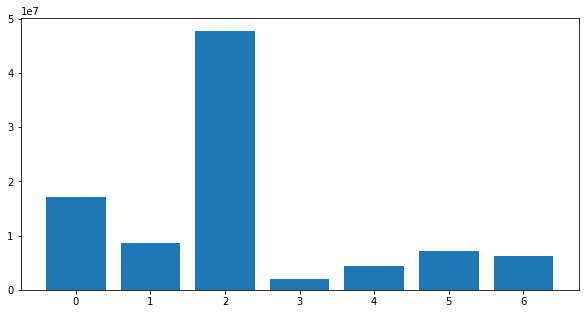

In [ ]:
# Отрисовка столбчатой диаграммы наполненности классов

plt.figure(figsize = (10, 5))
plt.bar(np.arange(num_classes), pix_count)
plt.show()

# PSP NET

https://www.researchgate.net/profile/Jian-Yang-77/publication/328852190/figure/fig4/AS:748544281554944@1555478272635/The-PSPNet-architecture-6.jpg

In [ ]:
def PSPNet(num_classes = num_classes, input_shape= (IMG_WIDTH, IMG_HEIGHT, 3)):
  img_input = Input(input_shape)  

  x = Conv2D(64, (3,3), padding='same')(img_input)
  x = BatchNormalization()(x)                                           
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)                                           
  x = Activation('relu')(x)  

  

  # sizes 1, 2, 3, 6 - поменяла на 1, 2, 4, 8 - так как не совпадали размеры

  first = MaxPooling2D(pool_size=(1,1))(x)
  first = Conv2D(64, (3,3), padding='same')(first)
  first = BatchNormalization()(first)                                            
  first = Activation('relu')(first)

  first = Conv2D(64, (3,3), padding='same')(first)
  first = BatchNormalization()(first)                                            
  first = Activation('relu')(first)
  first = Dropout(0.3)(first)


  second = MaxPooling2D(pool_size=(2,2))(x)
  second = Conv2D(64, (3,3), padding='same')(second)
  second = BatchNormalization()(second)                                            
  second = Activation('relu')(second)

  second = Conv2D(64, (3,3), padding='same')(second)
  second = BatchNormalization()(second)                                            
  second = Activation('relu')(second)
  second = Dropout(0.3)(second)
  

  third = MaxPooling2D(pool_size=(4,4), padding='same')(x)
  third = Conv2D(64, (3,3), padding='same')(third)
  third = BatchNormalization()(third)                                            
  third = Activation('relu')(third)

  third = Conv2D(64, (3,3), padding='same')(third)
  third = BatchNormalization()(third)                                            
  third = Activation('relu')(third)
  third = Dropout(0.3)(third)
  


  fourth = MaxPooling2D(pool_size=(8,8), padding='same')(x)
  fourth = Conv2D(64, (3,3), padding='same')(fourth)
  fourth = BatchNormalization()(fourth)                                            
  fourth = Activation('relu')(fourth)

  fourth = Conv2D(64, (3,3), padding='same')(fourth)
  fourth = BatchNormalization()(fourth)                                            
  fourth = Activation('relu')(fourth)
  fourth = Dropout(0.3)(fourth)
  

  #UPSAMPLE

  up_1 = UpSampling2D(size=(1,1))(first)
  up_1 = Conv2DTranspose(64, (3,3), padding='same')(up_1)
  up_1 = BatchNormalization()(up_1)                                           
  up_1 = Activation('relu')(up_1)  

  up_1 = Conv2DTranspose(64, (3,3), padding='same')(up_1)
  up_1 = BatchNormalization()(up_1)                                           
  up_1 = Activation('relu')(up_1)  



  up_2 = UpSampling2D(size=(2,2))(second)
  up_2 = Conv2DTranspose(64, (3,3), padding='same')(up_2)
  up_2 = BatchNormalization()(up_2)                                           
  up_2 = Activation('relu')(up_2)   

  up_2 = Conv2DTranspose(64, (3,3), padding='same')(up_2)
  up_2 = BatchNormalization()(up_2)                                           
  up_2 = Activation('relu')(up_2) 


  up_3 = UpSampling2D(size=(4,4))(third)
  up_3 = Conv2DTranspose(64, (3,3), padding='same')(up_3)
  up_3 = BatchNormalization()(up_3)                                           
  up_3 = Activation('relu')(up_3)   

  up_3 = Conv2DTranspose(64, (3,3), padding='same')(up_3)
  up_3 = BatchNormalization()(up_3)                                           
  up_3 = Activation('relu')(up_3)  
  


  up_4 = UpSampling2D(size=(8,8))(fourth)
  up_4 = Conv2DTranspose(64, (3,3), padding='same')(up_4)
  up_4 = BatchNormalization()(up_4)                                           
  up_4 = Activation('relu')(up_4)

  up_4 = Conv2DTranspose(64, (3,3), padding='same')(up_4)
  up_4 = BatchNormalization()(up_4)                                           
  up_4 = Activation('relu')(up_4)


  #CONCATENATE ALL

  x = concatenate([x, up_1, up_2, up_3, up_4])

  x = Conv2DTranspose(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Conv2D(num_classes, (1,1), activation='softmax', padding='same')(x) 

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])


  return model

In [ ]:
model_PSP7 = PSPNet(num_classes, (IMG_WIDTH, IMG_HEIGHT, 3))
model_PSP7.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_83 (Conv2D)             (None, 192, 256, 64  1792        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_153 (Batch  (None, 192, 256, 64  256        ['conv2d_83[0][0]']              
 Normalization)                 )                                                           

In [ ]:
gc.collect()

37153

In [ ]:
history = model_PSP7.fit(x_train, y_train7,
                         epochs=50, batch_size=12,
                         validation_data=(x_val, y_val7))

Epoch 1/50
159/159 [==============================] - 33s 200ms/step - loss: 1.7520 - sparse_categorical_accuracy: 0.4617 - val_loss: 2.5825 - val_sparse_categorical_accuracy: 0.4286
Epoch 2/50
159/159 [==============================] - 31s 195ms/step - loss: 1.3124 - sparse_categorical_accuracy: 0.6184 - val_loss: 1.5007 - val_sparse_categorical_accuracy: 0.5466
Epoch 3/50
159/159 [==============================] - 31s 195ms/step - loss: 1.1792 - sparse_categorical_accuracy: 0.6451 - val_loss: 1.4767 - val_sparse_categorical_accuracy: 0.5536
Epoch 4/50
159/159 [==============================] - 31s 195ms/step - loss: 1.0964 - sparse_categorical_accuracy: 0.6624 - val_loss: 1.4484 - val_sparse_categorical_accuracy: 0.5759
Epoch 5/50
159/159 [==============================] - 31s 195ms/step - loss: 1.0455 - sparse_categorical_accuracy: 0.6723 - val_loss: 1.2954 - val_sparse_categorical_accuracy: 0.5626
Epoch 6/50
159/159 [==============================] - 31s 195ms/step - loss: 1.0110 -

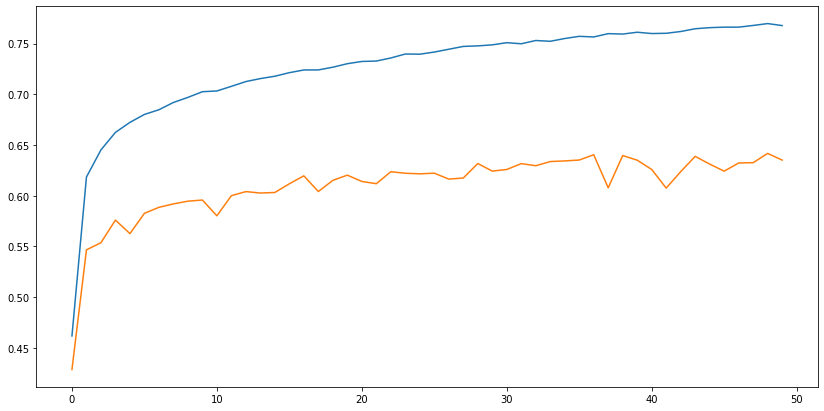

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

## Распознавание изображений

In [ ]:
# Функция визуализации процесса сегментации изображений

def process_images(model,        # обученная модель
                   count = 1     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)
    
    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15)) 
    
    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show() 

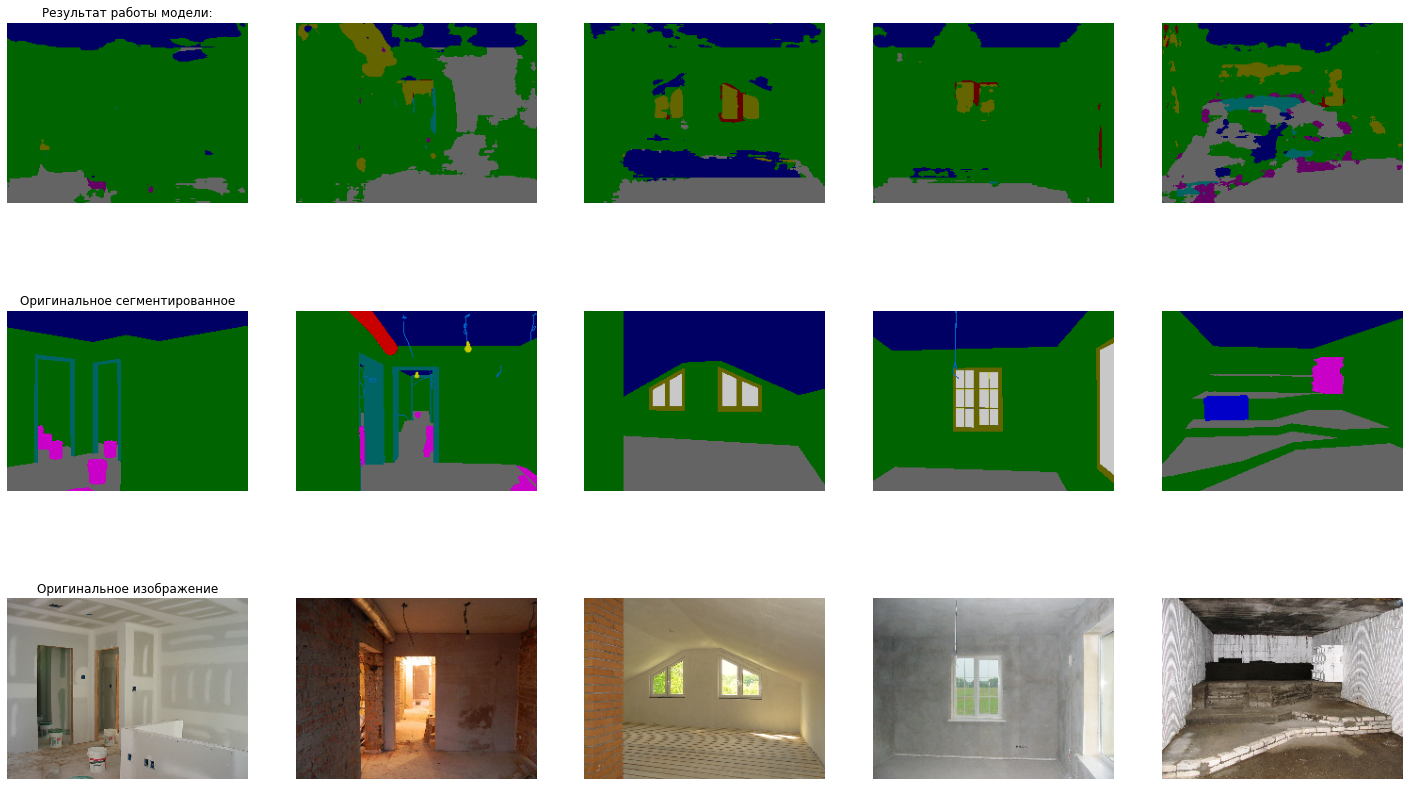

In [ ]:
# Отображение результатов работы модели

process_images(model_PSP7, 5)

**Выводы**
результат средненький, возможно, что данная архитектура не подходит или надо ее усложнять.Но расширенная UNET с урока отработала лучше